<a href="https://colab.research.google.com/github/futaoo/multiKG/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/climate-kgml/')

Mounted at /content/drive


In [2]:
!pip install sparqlwrapper

     |████████████████████████████████| 482 kB 9.3 MB/s 
     |████████████████████████████████| 41 kB 500 kB/s 


##Send Federated SPARQL Queries 

In [ ]:
from SPARQLWrapper import SPARQLWrapper, CSV

sparql = SPARQLWrapper("http://jresearch.ucd.ie/kg/climate/sparql")

sparql.setQuery("""
    BASE <http://jresearch.ucd.ie/climate-kg/>
    PREFIX ca_prop: <http://jresearch.ucd.ie/climate-kg/ca/property/>
    PREFIX sosa: <http://www.w3.org/ns/sosa/>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

    SELECT ?prcp ?tavg ?humidity ?date WHERE { #KG1
    ?obs1 ca_prop:sourceStation <resource/station/GHCND:EI000003969>;
            sosa:hasSimpleResult ?prcp;
            sosa:hasResult/ca_prop:withDataType <resource/datatype/PRCP>;
            sosa:resultTime ?date .
        {   
            SELECT ?tavg ?humidity ?date WHERE { #KG1
            ?obs2 ca_prop:sourceStation <resource/station/GHCND:EI000003969>;
            sosa:hasSimpleResult ?tavg;
            sosa:hasResult/ca_prop:withDataType <resource/datatype/TAVG>;
            sosa:resultTime ?date .
                {
                    SELECT ?humidity ?date WHERE{ #KG2
                    SERVICE <http://jresearch.ucd.ie/kg/air-pollutants/sparql> {
                        ?atm_obs sosa:madeBySensor <purpleair/sensor?id=26695>;
                                sosa:hasSimpleResult ?humidity; 
                                sosa:observedProperty <http://jresearch.ucd.ie/climate-kg/purpleair/Humidity>;
                                sosa:resultTime ?date.
                        }
                    }LIMIT 400
                }
            }LIMIT 400
        }
    }
""")

sparql.setReturnFormat(CSV)
results = sparql.query().convert()

# print(results)


##Load Data into a Dataframe

In [58]:
import pandas as pd
from io import StringIO


s=str(results,'utf-8')
data = StringIO(s) 
df=pd.read_csv(data)

In [59]:
import numpy

df["humidity"] = [float(str(e)[:-2]) for e in df["humidity"]]
df

,prcp,tavg,humidity,date
0,1.2,13.3,57.95,2019-06-01
1,0.0,14.9,51.37,2019-06-02
2,9.3,11.5,51.49,2019-06-03
3,19.7,10.4,69.54,2019-06-04
4,0.3,9.9,67.70,2019-06-05
...,...,...,...,...
362,0.0,15.3,44.68,2020-05-28
363,0.0,15.8,37.91,2020-05-29
364,0.0,14.9,37.19,2020-05-30
365,0.0,14.6,39.92,2020-05-31


## Predefined Functions to Create Machine Learning Compatiable Dataset

In [63]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


def prcp_map(x):
    value = 'yes' if x > 0 else 'no'
    return value

##Define Multivariated Time Series Rainfall Detection Problem

In [83]:
values12 = df.drop(columns=['date']).values
values1 = df[["prcp","tavg"]].values

In [86]:
df12 = series_to_supervised(values12,2,1).drop(columns=['var3(t)', 'var2(t)'])
df1 = series_to_supervised(values1,2,1).drop(columns=['var2(t)'])

In [87]:
df12

,var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t)
2,1.2,13.3,57.95,0.0,14.9,51.37,9.3
3,0.0,14.9,51.37,9.3,11.5,51.49,19.7
4,9.3,11.5,51.49,19.7,10.4,69.54,0.3
5,19.7,10.4,69.54,0.3,9.9,67.70,0.2
6,0.3,9.9,67.70,0.2,10.2,52.70,0.0
...,...,...,...,...,...,...,...
362,0.0,14.8,49.00,0.0,13.9,46.47,0.0
363,0.0,13.9,46.47,0.0,15.3,44.68,0.0
364,0.0,15.3,44.68,0.0,15.8,37.91,0.0
365,0.0,15.8,37.91,0.0,14.9,37.19,0.0


In [88]:
df1

,var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t)
2,1.2,13.3,0.0,14.9,9.3
3,0.0,14.9,9.3,11.5,19.7
4,9.3,11.5,19.7,10.4,0.3
5,19.7,10.4,0.3,9.9,0.2
6,0.3,9.9,0.2,10.2,0.0
...,...,...,...,...,...
362,0.0,14.8,0.0,13.9,0.0
363,0.0,13.9,0.0,15.3,0.0
364,0.0,15.3,0.0,15.8,0.0
365,0.0,15.8,0.0,14.9,0.0


## Machine Learning Differences in Augmented and Non-augmented KG Data

### Random Forest

              precision    recall  f1-score   support

          no       0.51      0.54      0.52        50
         yes       0.66      0.63      0.65        71

    accuracy                           0.60       121
   macro avg       0.59      0.59      0.59       121
weighted avg       0.60      0.60      0.60       121



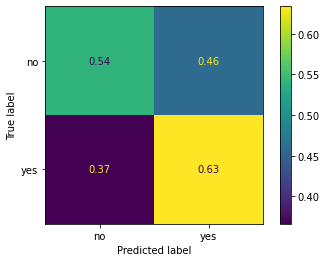

              precision    recall  f1-score   support

          no       0.63      0.54      0.58        50
         yes       0.71      0.77      0.74        71

    accuracy                           0.68       121
   macro avg       0.67      0.66      0.66       121
weighted avg       0.67      0.68      0.67       121



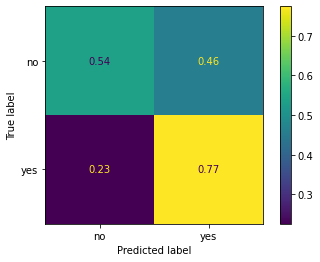

In [90]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier

from sklearn.neighbors import KNeighborsClassifier


for data in [df1, df12]:

    data['var1(t)'] = df_raw['var1(t)'].map(prcp_map)
    label_binarizer = preprocessing.LabelBinarizer()
    y = label_binarizer.fit_transform(data['var1(t)']).ravel()
    X = data.drop(columns='var1(t)')
    X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.33, stratify=y, random_state=42)

    clf = RandomForestClassifier(random_state=1235).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=label_binarizer.classes_))
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_binarizer.classes_).plot()
    plt.show()

### KNN

              precision    recall  f1-score   support

          no       0.49      0.68      0.57        50
         yes       0.69      0.51      0.59        71

    accuracy                           0.58       121
   macro avg       0.59      0.59      0.58       121
weighted avg       0.61      0.58      0.58       121



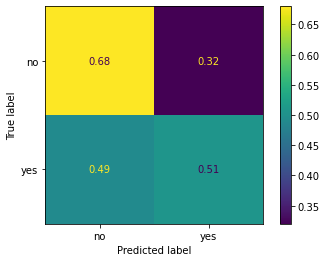

              precision    recall  f1-score   support

          no       0.56      0.56      0.56        50
         yes       0.69      0.69      0.69        71

    accuracy                           0.64       121
   macro avg       0.63      0.63      0.63       121
weighted avg       0.64      0.64      0.64       121



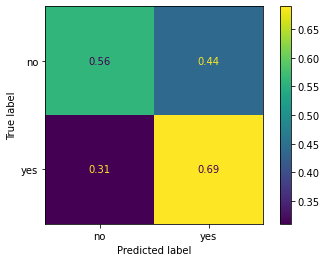

In [94]:
for data in [df1, df12]:

    data['var1(t)'] = df_raw['var1(t)'].map(prcp_map)
    label_binarizer = preprocessing.LabelBinarizer()
    y = label_binarizer.fit_transform(data['var1(t)']).ravel()
    X = data.drop(columns='var1(t)')
    X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.33, stratify=y, random_state=42)

    clf = KNeighborsClassifier(n_neighbors=8)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=label_binarizer.classes_))
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_binarizer.classes_).plot()
    plt.show()

### SVC

              precision    recall  f1-score   support

          no       0.54      0.44      0.48        50
         yes       0.65      0.73      0.69        71

    accuracy                           0.61       121
   macro avg       0.59      0.59      0.59       121
weighted avg       0.60      0.61      0.60       121



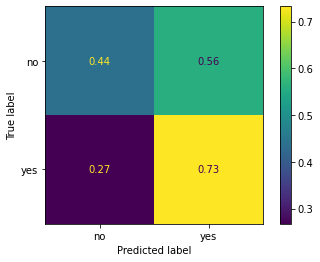

              precision    recall  f1-score   support

          no       0.69      0.48      0.56        50
         yes       0.70      0.85      0.76        71

    accuracy                           0.69       121
   macro avg       0.69      0.66      0.66       121
weighted avg       0.69      0.69      0.68       121



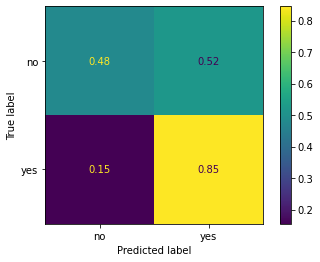

In [95]:
for data in [df1, df12]:

    data['var1(t)'] = df_raw['var1(t)'].map(prcp_map)
    label_binarizer = preprocessing.LabelBinarizer()
    y = label_binarizer.fit_transform(data['var1(t)']).ravel()
    X = data.drop(columns='var1(t)')
    X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.33, stratify=y, random_state=42)

    clf = SVC(gamma=0.01)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=label_binarizer.classes_))
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_binarizer.classes_).plot()
    plt.show()